In [1]:
import astropy.io.fits as fits
import numpy as np
from scipy.integrate import quad
import scipy.integrate as integrate
from scipy.optimize import curve_fit
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import Table, join
import os
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
import halomod as hm
import hmf
import treecorr

/home/astro/manasoi7/.conda/envs/project/lib/python3.12/site-packages/halomod/halo_model.py:32: UserWarning: Warning: Some Halo-Exclusion models have significant speedup when using Numba
  from .halo_exclusion import NoExclusion


In [2]:
import DarkVerse as dv


In [3]:
home_dir = os.path.expanduser('~')
directory_SN_X3 = "/home/astro/manasoi7/Master_Thesis/Results/SN-X3"
directory_SN_C3 = "/home/astro/manasoi7/Master_Thesis/Results/SN-C3"
directory_SN_E2 = "/home/astro/manasoi7/Master_Thesis/Results/SN-E2" 
directory_COSMOS = "/home/astro/manasoi7/Master_Thesis/Results/COSMOS" 
res = os.path.join(home_dir, 'Master_Thesis', 'Results')

### re-run IC computation with fit bias value
### assign IC to self.IC_list

In [4]:
class FieldBiasEstimator:
    def __init__(self, xi_m, mask):
        """
        Initialize with matter correlation and mask that's common to all fields
        
        Parameters:
        - xi_m: np.array, matter-matter angular correlation function
        - mask: np.array, boolean mask for selecting the 2-halo term
        """
        self.xi_m = xi_m
        self.mask = mask
        self.fields = []
        
    def add_field(self, field_name, xi_g, w_theta, w_theta_error, sum_rr):
        """
        Add data for a single field
        
        Parameters:
        - field_name: str, identifier for the field
        - xi_g: np.array, galaxy-galaxy correlation for this field
        - w_theta: np.array, observed correlation function
        - w_theta_error: np.array, errors for observed correlation
        - sum_rr: np.array, RR pair counts for this field
        """
        self.fields.append({
            'name': field_name,
            'xi_g': xi_g, 
            'w_theta': w_theta,
            'w_error': w_theta_error,
            'sum_rr': sum_rr,
            'IC': None,
            'bias': None,
            'bias_error': None
        })
    
    def _calculate_IC(self, wg_no_ic, sum_rr):
        """Calculate integral constraint for given correlation and RR counts"""
        return np.sum(wg_no_ic * sum_rr) / np.sum(sum_rr)
    
    def _model(self, wdm, b, IC):
        """Model function with current IC"""
        return (wdm * b**2 - IC)[self.mask]
    
    def fit_individual_fields(self):
        """Fit bias for each field separately"""
        results = []
        for field in self.fields:
            try:
                # Initial IC estimate using xi_g
                field['IC'] = self._calculate_IC(field['xi_g'], field['sum_rr'])
                
                # Perform fit
                popt, pcov = curve_fit(
                    lambda wdm, b: self._model(wdm, b, field['IC']),
                    self.xi_m,
                    field['w_theta'][self.mask], 
                    sigma=field['w_error'][self.mask],
                    p0=[1.0],
                    maxfev=10000
                )
                
                field['bias'] = popt[0]
                field['bias_error'] = np.sqrt(np.diag(pcov))[0]
                
                # Update IC with best-fit model
                wg_no_ic_fit = self.xi_m * field['bias']**2
                field['IC'] = self._calculate_IC(wg_no_ic_fit, field['sum_rr'])
                
                results.append((field['name'], field['bias'], field['bias_error'], field['IC']))
                
            except RuntimeError:
                results.append((field['name'], np.nan, np.nan, np.nan))
        
        return results
    
    def fit_combined(self):
        """Fit combined data from all fields to get global bias"""
        if not self.fields:
            raise ValueError("No fields added for fitting")
            
        # Stack all field data
        all_w_theta = np.array([f['w_theta'][self.mask] for f in self.fields])
        all_errors = np.array([f['w_error'][self.mask] for f in self.fields])
        weights = 1.0 / (all_errors**2)
        
        # Weighted average of the observations
        combined_w = np.sum(all_w_theta * weights, axis=0) / np.sum(weights, axis=0)
        combined_err = 1.0 / np.sqrt(np.sum(1.0 / all_errors**2, axis=0))
        
        # Use mean of individual ICs as starting point
        initial_IC = np.mean([f['IC'] for f in self.fields if f['IC'] is not None])
        
        try:
            popt, pcov = curve_fit(
                lambda wdm, b: self._model(wdm, b, initial_IC),
                self.xi_m,
                combined_w,
                sigma=combined_err,
                p0=[1.0],
                maxfev=10000
            )
            
            global_bias = popt[0]
            global_error = np.sqrt(np.diag(pcov))[0]
            
            return global_bias, global_error
            
        except RuntimeError:
            return np.nan, np.nan

    def get_field_models(self, global_bias):
        models = {}
        for field in self.fields:
            if field['IC'] is not None:
                models[field['name']] = self._model(self.xi_m, global_bias, field['IC'])
            else:
                models[field['name']] = None
        return models
             
   

In [24]:
home_dir = os.path.expanduser('~')
thesis_path = os.path.join(home_dir, 'Master_Thesis', 'DATA')

# Field details
fields = {
    "SN-X3": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_SN-X3_zm.fits",
        "masked": "SN-X3_masked_cat.fits",
        "randoms": "SN-X3_randoms_ugriz_trim_video.fits"
    },
    "SN-C3": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_SN-C3_zm.fits",
        "masked": "SN-C3_masked_cat.fits",
        "randoms": "SN-C3_randoms_ugriz_trim_video.fits"
    },
    "SN-E2": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_SN-E2_zm.fits",
        "masked": "SN-E2_masked_cat.fits",
        "randoms": "SN-E2_randoms_ugriz_trim_video.fits"
    },
    "COSMOS": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_COSMOS_zm.fits",
        "masked": "COSMOS_masked_cat.fits",
        "randoms": "COSMOS_randoms_ugriz_trim_video.fits"
    }
}


# Configurations
z_min, z_max = 0.6, 0.7
SM_min, SM_max = 10.5, 11

config = {
    'min_sep': 0.003,
    'max_sep': 1.78,
    'bin_size': 0.1,
    'sep_units': 'degrees',
    'var_method': 'shot'
}

# Initialize the bias estimator with common matter correlation and mask
# (We'll use the first field's xi_m and mask as reference since they should be similar)
first_field = list(fields.keys())[0]
first_catalog = Table.read(os.path.join(thesis_path, fields[first_field]["catalog"]))
first_masked = Table.read(os.path.join(thesis_path, fields[first_field]["masked"]))
first_catalog = join(first_catalog, first_masked, keys='id')
first_catalog.rename_columns(['ra_1', 'dec_1'], ['ra', 'dec'])
first_randoms = Table.read(os.path.join(thesis_path, fields[first_field]["randoms"]))

first_subsample = dv.Subsample(catalog=first_catalog, randoms=first_randoms,
                             z_min=z_min, z_max=z_max,
                             SM_min=SM_min, SM_max=SM_max,
                             config=config)
first_results = first_subsample.get_results()

# Initialize estimator with matter correlation and mask that's common to all fields
estimator = FieldBiasEstimator(
    xi_m=np.array(first_results['xi_m']),
    mask=(np.array(first_results['theta']) >= 0.1) & (np.array(first_results['theta']) <= 0.4)
)

# Process each field
for field, paths in fields.items():
    print(f"\n🔹 Processing field: {field}")
    
    # Load data
    catalog = Table.read(os.path.join(thesis_path, paths["catalog"]))
    masked = Table.read(os.path.join(thesis_path, paths["masked"]))
    catalog = join(catalog, masked, keys='id')
    catalog.rename_columns(['ra_1', 'dec_1'], ['ra', 'dec'])
    randoms = Table.read(os.path.join(thesis_path, paths["randoms"]))

    # Compute subsample
    subsample = dv.Subsample(catalog=catalog, randoms=randoms,
                           z_min=z_min, z_max=z_max,
                           SM_min=SM_min, SM_max=SM_max,
                           config=config)
    results = subsample.get_results()

    # Add field data to estimator
    estimator.add_field(
        field_name=field,
        xi_g=np.array(results['xi_g']),
        w_theta=np.array(results['w_theta']),
        w_theta_error=np.sqrt(np.array(results['var_w_theta_bootstrap'])),  # Using bootstrap errors
        sum_rr=np.array(results['rr_counts'])
    )

# 1. Fit individual fields and print results
print("\nIndividual Field Results:")
individual_results = estimator.fit_individual_fields()
for name, b, be, ic in individual_results:
    print(f"{name}: b = {b:.3f} ± {be:.3f}, IC = {ic:.4f}")

# 2. Get combined bias estimate
global_b, global_be = estimator.fit_combined()
print(f"\nGlobal bias estimate: {global_b:.3f} ± {global_be:.3f}")

# 3. Get field-specific models using global bias
field_models = estimator.get_field_models(global_b)



The following patch numbers have no objects: {28}
This may be a problem depending on your use case.

🔹 Processing field: SN-X3
The following patch numbers have no objects: {28}
This may be a problem depending on your use case.
The following patch numbers have no objects: {28}
This may be a problem depending on your use case.

🔹 Processing field: SN-C3
The following patch numbers have no objects: {39}
This may be a problem depending on your use case.
The following patch numbers have no objects: {27}
This may be a problem depending on your use case.
The following patch numbers have no objects: {39}
This may be a problem depending on your use case.

🔹 Processing field: SN-E2
The following patch numbers have no objects: {33}
This may be a problem depending on your use case.
The following patch numbers have no objects: {40}
This may be a problem depending on your use case.
The following patch numbers have no objects: {40}
This may be a problem depending on your use case.
The following patch

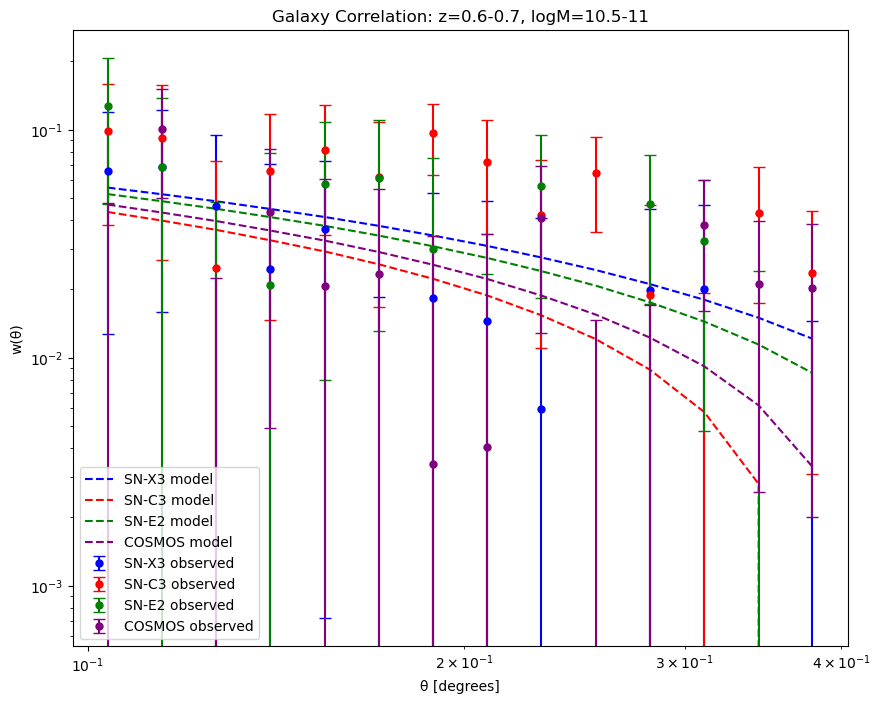

In [25]:
colors = {"SN-X3": "blue", "SN-C3": "red", "SN-E2": "green", "COSMOS": "purple"}

plt.figure(figsize=(10, 8))

theta = np.array(first_results['theta'])  # Using first field's theta as reference

for field_data in estimator.fields:
    field_name = field_data['name']
    if field_name in field_models and field_models[field_name] is not None:
        
        # Plot observed data
        plt.errorbar(
            theta[estimator.mask],
            field_data['w_theta'][estimator.mask],
            yerr=field_data['w_error'][estimator.mask],
            fmt='o', color=colors.get(field_name, 'black'),
             capsize=4, markersize=5, 
            label=f'{field_name} observed'
        )
        
        # Plot model
        plt.plot(
            theta[estimator.mask],
            field_models[field_name],
            color=colors.get(field_name, 'black'), 
            linestyle='--', 
            label=f'{field_name} model '
        )

plt.xscale('log')
plt.yscale('log')
plt.xlabel('θ [degrees]')
plt.ylabel('w(θ)')
plt.title(f'Galaxy Correlation: z={z_min}-{z_max}, logM={SM_min}-{SM_max}')
plt.legend()
plt.show()

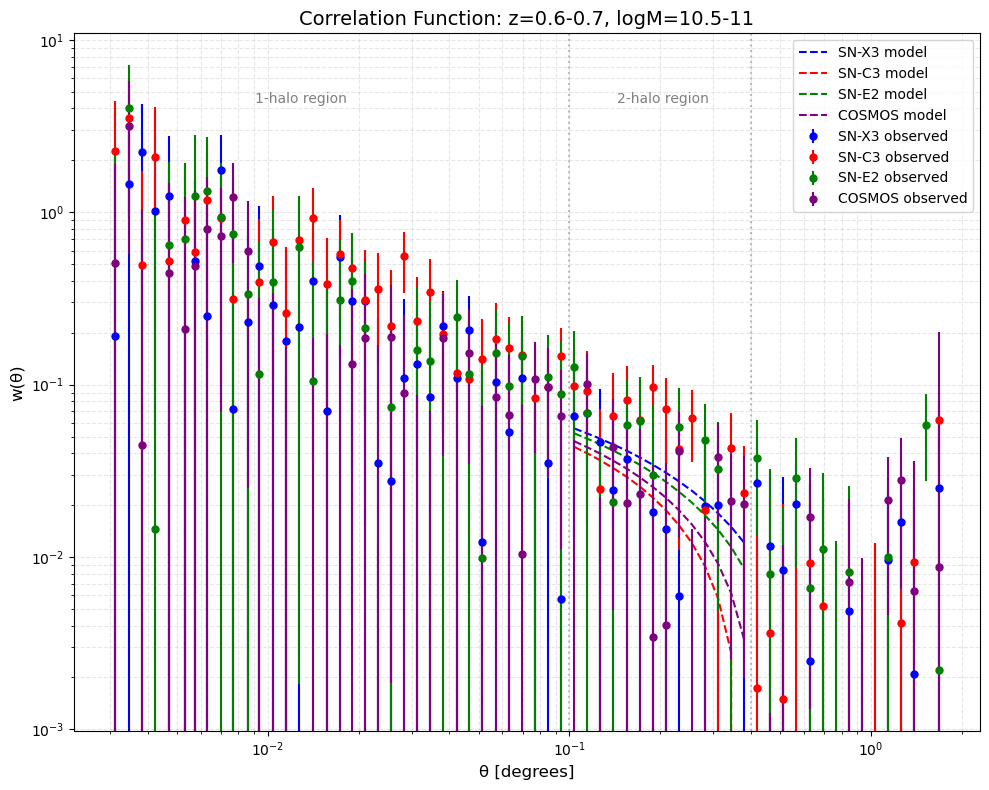

In [26]:

plt.figure(figsize=(10, 8))

for field_data in estimator.fields:
    field_name = field_data['name']
    if field_name in field_models and field_models[field_name] is not None:
        # Plot FULL observed data (not just masked region)
        plt.errorbar(
            theta,
            field_data['w_theta'],
            yerr=field_data['w_error'],
            fmt='o', color=colors.get(field_name, 'black'),
            markersize=5,
            label=f'{field_name} observed'
        )
        
        
        # Plot model
        plt.plot(
            theta[estimator.mask],
            field_models[field_name],
            color=colors.get(field_name, 'black'), 
            linestyle='--', 
            label=f'{field_name} model '
        )

# Add reference lines
plt.axvline(0.1, color='gray', linestyle=':', alpha=0.5)  # Show original mask boundary
plt.axvline(0.4, color='gray', linestyle=':', alpha=0.5)

# Formatting
plt.xscale('log')
plt.yscale('log')
plt.xlabel('θ [degrees]', fontsize=12)
plt.ylabel('w(θ)', fontsize=12)
plt.title(f'Correlation Function: z={z_min}-{z_max}, logM={SM_min}-{SM_max}', fontsize=14)
plt.legend(fontsize=10, framealpha=0.8)
plt.grid(True, which="both", ls="--", alpha=0.3)

# Add annotations
plt.text(0.2, 0.9, "1-halo region", transform=plt.gca().transAxes, color='gray')
plt.text(0.6, 0.9, "2-halo region", transform=plt.gca().transAxes, color='gray')


plt.tight_layout()
plt.show()

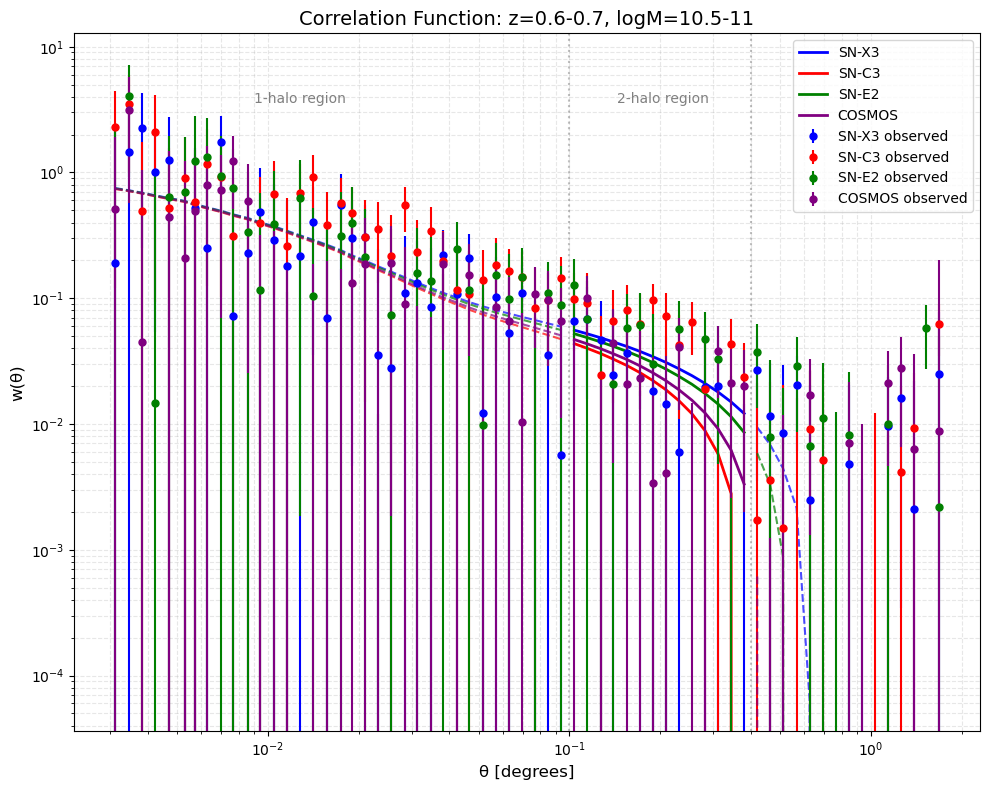

In [27]:
plt.figure(figsize=(10, 8))

for field_data in estimator.fields:
    field_name = field_data['name']
    if field_name in field_models and field_models[field_name] is not None:
        
        # Get theta values (using first field as reference)
        theta = np.array(first_results['theta'])
        
        # Plot observed data points
        plt.errorbar(
            theta,
            field_data['w_theta'],
            yerr=field_data['w_error'],
            fmt='o', 
            color=colors.get(field_name, 'black'),
            markersize=5,
            label=f'{field_name} observed'
        )
        
        # Reconstruct full model
        full_wdm = np.array(first_results['xi_m'])
        full_IC = field_data['IC']
        full_model = full_wdm * global_b**2 - full_IC
        
        # Create masks for different regions
        two_halo_mask = (theta >= 0.1) & (theta <= 0.4)  # 2-halo region
        one_halo_mask = theta < 0.1                      # 1-halo region
        extended_mask = theta > 0.4                      # Extended 2-halo
        
        # Plot 2-halo region (solid line)
        plt.plot(
            theta[two_halo_mask],
            full_model[two_halo_mask],
            color=colors.get(field_name, 'black'),
            linestyle='-',
            linewidth=2,label=f'{field_name}')
            #label=f'{field_name} model (b={global_b:.2f})' if field_name == list(fields.keys())[0] else ""
            # Only label for first field to avoid duplicate legends)
        
        # Plot 1-halo region (dashed line)
        plt.plot(
            theta[one_halo_mask],
            full_model[one_halo_mask],
            color=colors.get(field_name, 'black'),
            linestyle='--',
            linewidth=1.5,
            alpha=0.7
        )
        
        # Plot extended 2-halo region (dashed line)
        plt.plot(
            theta[extended_mask],
            full_model[extended_mask],
            color=colors.get(field_name, 'black'),
            linestyle='--',
            linewidth=1.5,
            alpha=0.7
        )

# Add reference lines and annotations
plt.axvline(0.1, color='gray', linestyle=':', alpha=0.5)  
plt.axvline(0.4, color='gray', linestyle=':', alpha=0.5)

# Formatting
plt.xscale('log')
plt.yscale('log')
plt.xlabel('θ [degrees]', fontsize=12)
plt.ylabel('w(θ)', fontsize=12)
plt.title(f'Correlation Function: z={z_min}-{z_max}, logM={SM_min}-{SM_max}', fontsize=14)

# Improved legend handling
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # Remove duplicates
plt.legend(by_label.values(), by_label.keys(), fontsize=10, framealpha=0.8)

plt.grid(True, which="both", ls="--", alpha=0.3)

plt.text(0.25, 0.9, "1-halo region", transform=plt.gca().transAxes, color='gray', ha='center')
plt.text(0.65, 0.9, "2-halo region", transform=plt.gca().transAxes, color='gray', ha='center')

plt.savefig(os.path.join(res, 'b-4fields-highSM'))


plt.tight_layout()
plt.show()

# Evolution of clustering with redshift

In [9]:
home_dir = os.path.expanduser('~')
thesis_path = os.path.join(home_dir, 'Master_Thesis', 'DATA')

# Field details
fields = {
    "SN-X3": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_SN-X3_zm.fits",
        "masked": "SN-X3_masked_cat.fits",
        "randoms": "SN-X3_randoms_ugriz_trim_video.fits"
    },
    "SN-C3": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_SN-C3_zm.fits",
        "masked": "SN-C3_masked_cat.fits",
        "randoms": "SN-C3_randoms_ugriz_trim_video.fits"
    },
    "SN-E2": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_SN-E2_zm.fits",
        "masked": "SN-E2_masked_cat.fits",
        "randoms": "SN-E2_randoms_ugriz_trim_video.fits"
    },
    "COSMOS": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_COSMOS_zm.fits",
        "masked": "COSMOS_masked_cat.fits",
        "randoms": "COSMOS_randoms_ugriz_trim_video.fits"
    }
}

config = {
    'min_sep': 0.003,
    'max_sep': 1.78,
    'bin_size': 0.1,
    'sep_units': 'degrees',
    'var_method': 'shot'
}

SM_min, SM_max = 10.5, 11.0
z_ranges = [(0.3, 0.4), (0.4, 0.5), (0.5, 0.6), (0.6, 0.7), (0.7, 0.8)]
colors = ["blue", "green", "red", "purple", "orange"]  # Different color for each redshift bin


# Initialize storage for all results
all_results = {z_range: {} for z_range in z_ranges}

# Process each redshift range
for z_min, z_max in z_ranges:
    print(f"\n\n🔹 Processing redshift range {z_min}-{z_max}")
    
    # Initialize bias estimator for this redshift range (using first field as reference)
    first_field = list(fields.keys())[0]
    first_catalog = Table.read(os.path.join(thesis_path, fields[first_field]["catalog"]))
    first_masked = Table.read(os.path.join(thesis_path, fields[first_field]["masked"]))
    first_catalog = join(first_catalog, first_masked, keys='id')
    first_catalog.rename_columns(['ra_1', 'dec_1'], ['ra', 'dec'])
    first_randoms = Table.read(os.path.join(thesis_path, fields[first_field]["randoms"]))
    
    first_subsample = dv.Subsample(
        catalog=first_catalog,
        randoms=first_randoms,
        z_min=z_min,
        z_max=z_max,
        SM_min=SM_min,
        SM_max=SM_max,
        config=config
    )
    first_results = first_subsample.get_results()
    
    estimator = FieldBiasEstimator(
        xi_m=np.array(first_results['xi_m']),
        mask=(np.array(first_results['theta']) >= 0.1) & (np.array(first_results['theta']) <= 0.4)
    )
    
    # Process each field for this redshift range
    for field, paths in fields.items():
        print(f"\n🔸 Processing field: {field}")
        
        # Load data
        catalog = Table.read(os.path.join(thesis_path, paths["catalog"]))
        masked = Table.read(os.path.join(thesis_path, paths["masked"]))
        catalog = join(catalog, masked, keys='id')
        catalog.rename_columns(['ra_1', 'dec_1'], ['ra', 'dec'])
        randoms = Table.read(os.path.join(thesis_path, paths["randoms"]))
        
        # Compute subsample
        subsample = dv.Subsample(
            catalog=catalog,
            randoms=randoms,
            z_min=z_min,
            z_max=z_max,
            SM_min=SM_min,
            SM_max=SM_max,
            config=config
        )
        results = subsample.get_results()
        
        # Add to estimator
        estimator.add_field(
            field_name=field,
            xi_g=np.array(results['xi_g']),
            w_theta=np.array(results['w_theta']),
            w_theta_error=np.sqrt(np.array(results['var_w_theta_bootstrap'])),  # Using bootstrap errors
            sum_rr=np.array(results['rr_counts'])
        )
    
    # 1. Fit individual fields
    print("\nIndividual Field Results:")
    individual_results = estimator.fit_individual_fields()
    for name, b, be, ic in individual_results:
        print(f"{name}: b = {b:.3f} ± {be:.3f}, IC = {ic:.4f}")
    
    # 2. Get combined bias estimate
    global_b, global_be = estimator.fit_combined()
    print(f"\nGlobal bias estimate: {global_b:.3f} ± {global_be:.3f}")
    
    # 3. Store results
    all_results[(z_min, z_max)] = {
        'individual': individual_results,
        'global_b': global_b,
        'global_be': global_be,
        'estimator': estimator
    }





🔹 Processing redshift range 0.3-0.4
The following patch numbers have no objects: {22}
This may be a problem depending on your use case.
The following patch numbers have no objects: {24}
This may be a problem depending on your use case.
The following patch numbers have no objects: {16, 34}
This may be a problem depending on your use case.
The following patch numbers have no objects: {24}
This may be a problem depending on your use case.
The following patch numbers have no objects: {23}
This may be a problem depending on your use case.
The following patch numbers have no objects: {20}
This may be a problem depending on your use case.


/home/astro/manasoi7/.conda/envs/project/lib/python3.12/site-packages/hmf/density_field/transfer_models.py:233: UserWarning: 'extrapolate_with_eh' was not set. Defaulting to True, which is different behaviour than versions <=3.4.4. This warning may be removed in v4.0. Silence it by setting extrapolate_with_eh explicitly.
  warnings.warn(
/home/astro/manasoi7/.conda/envs/project/lib/python3.12/site-packages/halomod/halo_model.py:784: UserWarning: You are using an un-normalized mass function and bias function pair.Bias Tinker10 has the following paired HMF model: (). Matter correlations are not well-defined.
  tools.norm_warn(self)



🔸 Processing field: SN-X3
The following patch numbers have no objects: {42}
This may be a problem depending on your use case.
The following patch numbers have no objects: {13, 38}
This may be a problem depending on your use case.
The following patch numbers have no objects: {26}
This may be a problem depending on your use case.

🔸 Processing field: SN-C3
The following patch numbers have no objects: {33}
This may be a problem depending on your use case.
The following patch numbers have no objects: {31}
This may be a problem depending on your use case.

🔸 Processing field: SN-E2
The following patch numbers have no objects: {21}
This may be a problem depending on your use case.
The following patch numbers have no objects: {9}
This may be a problem depending on your use case.
The following patch numbers have no objects: {20}
This may be a problem depending on your use case.
The following patch numbers have no objects: {7}
This may be a problem depending on your use case.
The following pat

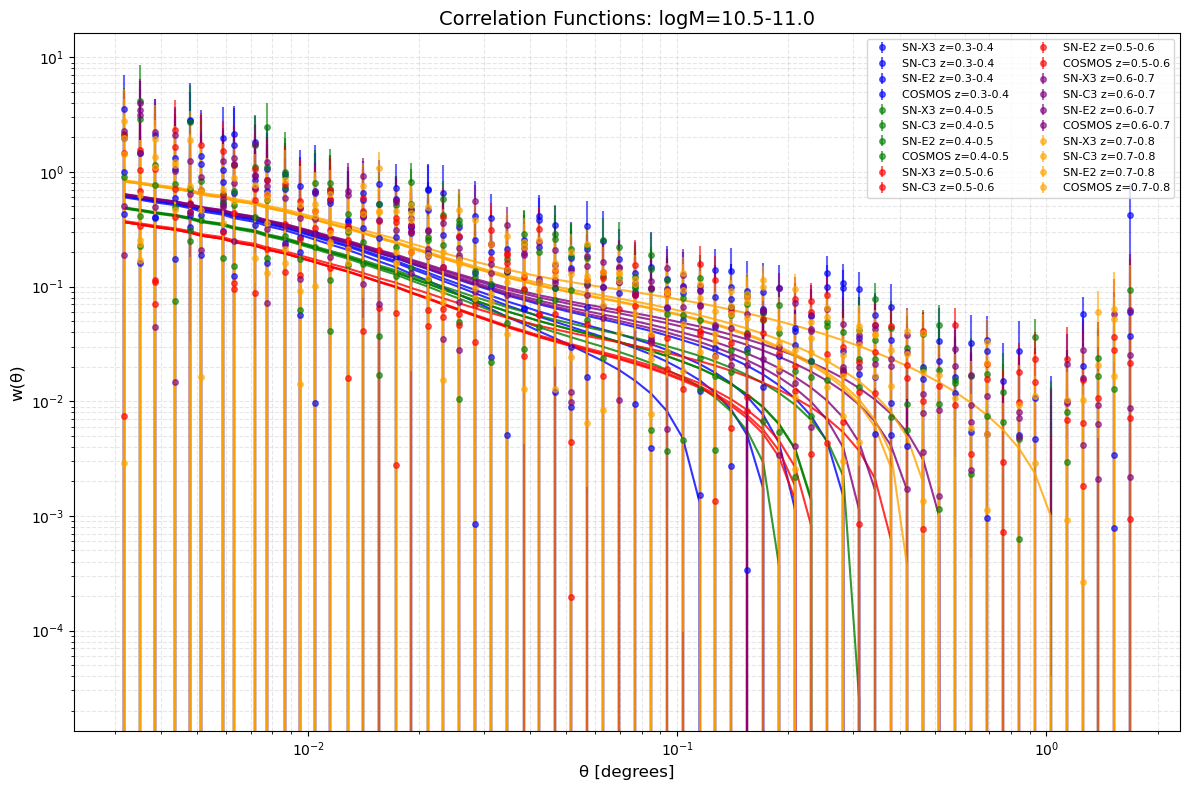



Summary of Bias Estimates:
Redshift 	Global Bias	Error
0.3-0.4		1.068		0.038
0.4-0.5		0.942		0.044
0.5-0.6		0.817		0.050
0.6-0.7		1.065		0.046
0.7-0.8		1.215		0.045


In [23]:
def plot_redshift_ranges(results_dict):
    plt.figure(figsize=(12, 8))
    color_idx = 0
    
    for (z_min, z_max), results in results_dict.items():
        estimator = results['estimator']
        global_b = results['global_b']
        
        # Get color for this redshift range
        color = colors[color_idx % len(colors)]
        color_idx += 1
        
        # Plot all fields for this redshift range
        for field_data in estimator.fields:
            field_name = field_data['name']
            
            theta = np.array(first_results['theta'])
            w_theta = field_data['w_theta']
                        

            
            # Plot observed data
            plt.errorbar(
                theta,
                w_theta,
                yerr=field_data['w_error'],
                fmt='o',
                color=color,
                markersize=4,
                alpha=0.6,
                label=f'{field_name} z={z_min}-{z_max}'
            )
            
            # Plot model
            full_wdm = np.array(first_results['xi_m'])
            full_IC = field_data['IC']
            full_model = full_wdm * global_b**2 - full_IC
            
            plt.plot(
                theta,
                full_model,
                color=color,
                linestyle='-',
                linewidth=1.5,
                alpha=0.8
            )
    
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('θ [degrees]', fontsize=12)
    plt.ylabel('w(θ)', fontsize=12)
    plt.title(f'Correlation Functions: logM={SM_min}-{SM_max}', fontsize=14)
    plt.legend(fontsize=8, ncol=2, framealpha=0.8)
    plt.grid(True, which="both", ls="--", alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_redshift_ranges(all_results)

print("\n\nSummary of Bias Estimates:")
print("Redshift \tGlobal Bias\tError")
for (z_min, z_max), results in all_results.items():
    print(f"{z_min}-{z_max}\t\t{results['global_b']:.3f}\t\t{results['global_be']:.3f}")

# Next steps
1) FIGURE WHAT IN THE FUCK IS GOING ON WITH THESE ERRORS 
2)  do diff plots
3) i have only one parameter aka my bias and so i should fit in my HOD model 3 params
4) clean up a bit and do more efficiently
5) then do more realistic nz (redshift distributution)
   

### 2)


Redshift        Global Bias     Error          
---------------------------------------------
0.3-0.4         1.068           0.038          
0.4-0.5         0.942           0.044          
0.5-0.6         0.817           0.050          
0.6-0.7         1.065           0.046          
0.7-0.8         1.215           0.045          


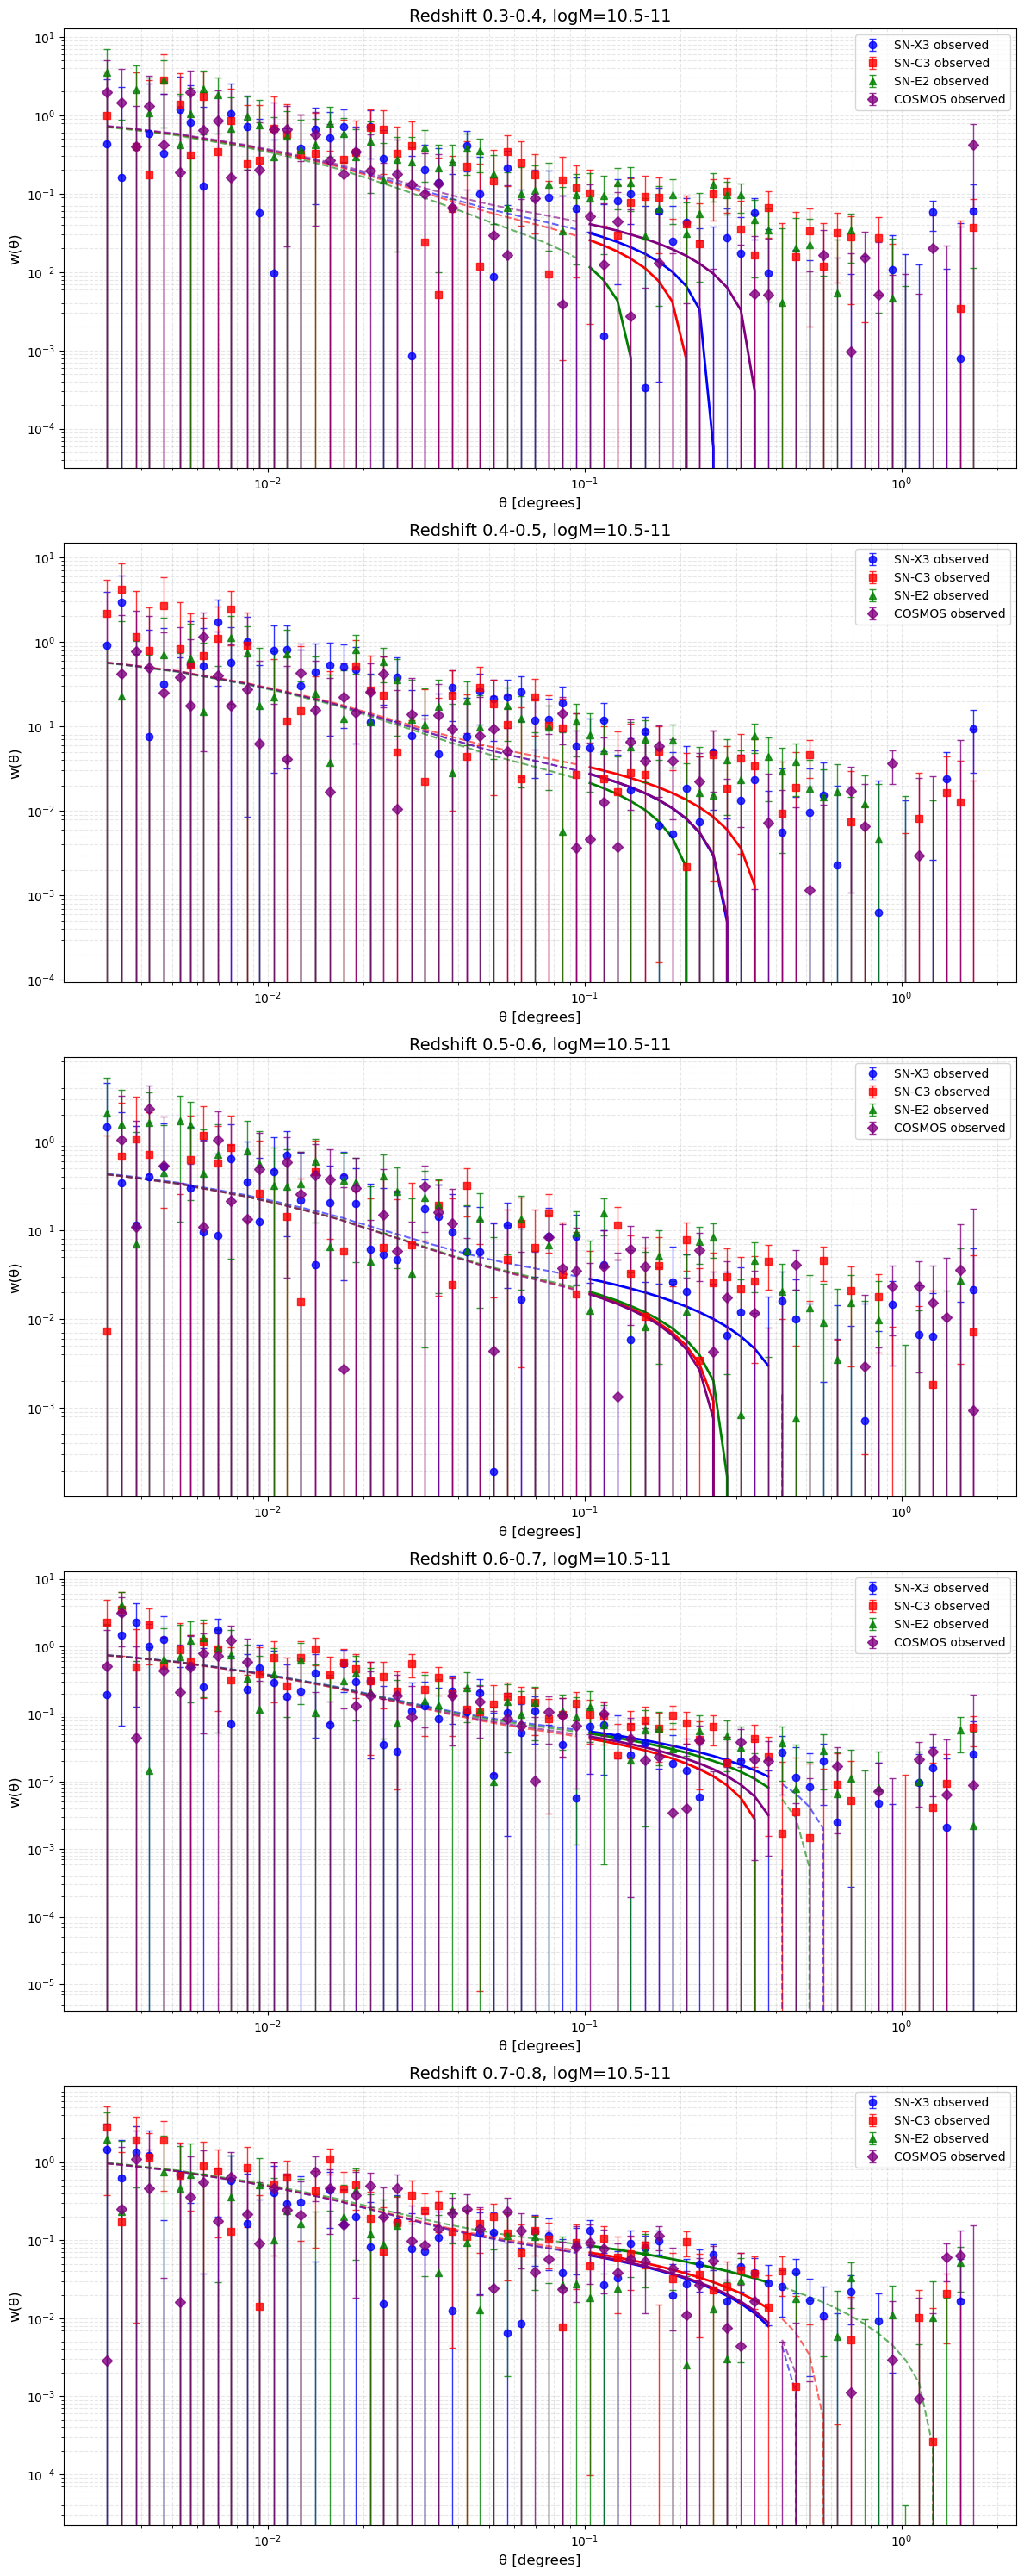

In [130]:
def plot_redshift_ranges_separate(results_dict):
    # Create figure with subplots for each redshift range
    n_redshifts = len(results_dict)
    fig, axes = plt.subplots(n_redshifts, 1, figsize=(12, 6*n_redshifts))
    
    # If only one redshift range, make axes a list for consistency
    if n_redshifts == 1:
        axes = [axes]
    
    # Field colors and markers for better distinction
    field_colors = {"SN-X3": "blue", "SN-C3": "red", "SN-E2": "green", "COSMOS": "purple"}
    field_markers = {"SN-X3": "o", "SN-C3": "s", "SN-E2": "^", "COSMOS": "D"}
    
    for ax, ((z_min, z_max), results) in zip(axes, results_dict.items()):
        estimator = results['estimator']
        global_b = results['global_b']
        
        # Plot all fields for this redshift range
        for field_data in estimator.fields:
            field_name = field_data['name']
            
            theta = np.array(first_results['theta'])
            
            # Use field's own values (not first_results)
            w_theta = np.array(field_data['w_theta'])
            w_error = np.array(field_data['w_error'])
            
            # Plot observed data 
            ax.errorbar(
                theta,
                w_theta,
                yerr=w_error,
                fmt=field_markers[field_name],
                color=field_colors[field_name],
                markersize=6,
                alpha=0.8,
                label=f'{field_name} observed',
                capsize=3,
                elinewidth=1
            )
            
            # Reconstruct and plot model using field's own xi_m
            full_wdm = np.array(first_results['xi_m'])
            full_IC = field_data['IC']
            full_model = full_wdm * global_b**2 - full_IC
            

            two_halo_mask = (theta >= 0.1) & (theta <= 0.4)  # 2-halo region
            one_halo_mask = theta < 0.1                      # 1-halo region
            extended_mask = theta > 0.4                      # Extended 2-halo


            
            ax.plot(
                theta[two_halo_mask],
                full_model[two_halo_mask],
                color=field_colors[field_name],
                linestyle='-',
                linewidth=2,
            )
            ax.plot(
                theta[one_halo_mask],
                full_model[one_halo_mask],
                color=field_colors[field_name],
                linestyle='--',
                linewidth=1.5,
                alpha=0.6
            )


        
            # Plot extended 2-halo region (dashed line)
            ax.plot(
                theta[extended_mask],
                full_model[extended_mask],
                color=field_colors[field_name],
                linestyle='--',
                linewidth=1.5,
                alpha=0.6
            )
        
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlabel('θ [degrees]', fontsize=12)
        ax.set_ylabel('w(θ)', fontsize=12)
        ax.set_title(f'Redshift {z_min}-{z_max}, logM={SM_min}-{SM_max}', fontsize=14)
        ax.legend(fontsize=10, framealpha=0.8)
        ax.grid(True, which="both", ls="--", alpha=0.3)

    
    plt.tight_layout()
    plt.show()



redshifts = []
biases = []
errors = []

print("\n{:<15} {:<15} {:<15}".format("Redshift", "Global Bias", "Error"))
print("-"*45)
for (z_min, z_max), results in all_results.items():
    print("{:<15} {:<15.3f} {:<15.3f}".format(
        f"{z_min}-{z_max}",
        results['global_b'],
        results['global_be']
    ))
    z_mid = (z_min + z_max) / 2
    redshifts.append(z_mid)
    biases.append(results['global_b'])
    errors.append(results['global_be'])



plot_redshift_ranges_separate(all_results)



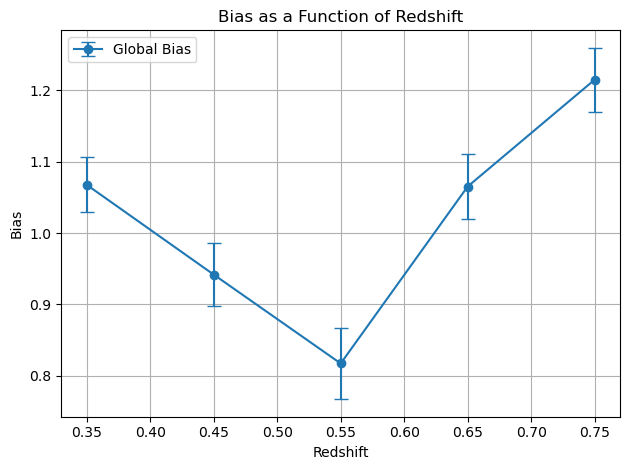


Redshift        Global Bias     Error          
---------------------------------------------
0.3-0.4         1.068           0.038          
0.4-0.5         0.942           0.044          
0.5-0.6         0.817           0.050          
0.6-0.7         1.065           0.046          
0.7-0.8         1.215           0.045          


In [131]:

plt.errorbar(redshifts, biases, yerr=errors, fmt='o-', capsize=5, label='Global Bias')
plt.xlabel('Redshift')
plt.ylabel('Bias')
plt.title('Bias as a Function of Redshift')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


print("\n{:<15} {:<15} {:<15}".format("Redshift", "Global Bias", "Error"))
print("-"*45)
for (z_min, z_max), results in all_results.items():
    print("{:<15} {:<15.3f} {:<15.3f}".format(
        f"{z_min}-{z_max}",
        results['global_b'],
        results['global_be']
    ))

### 3) i have only one parameter aka my bias and so i should fit in my HOD model 3 params so improve my class Subsample:


In [112]:
class Selection:
    def __init__(self, catalog, randoms, z_min, z_max, SM_min, SM_max, config, w_theta=None, theta=None):
        """
        Initialize a subsample of galaxies with given redshift and stellar mass limits.

        Parameters:
        - catalog: Galaxy catalog data
        - randoms: Random catalog for correlation function
        - z_min, z_max: Redshift range limits
        - SM_min, SM_max: Stellar mass range limits
        - config: Configuration for correlation function computation
        - w_theta, theta: Optional pre-computed correlation function
        """
        self.catalog = catalog
        self.randoms = randoms
        self.z_min = z_min
        self.z_max = z_max
        self.SM_min = SM_min
        self.SM_max = SM_max
        self.config = config
        self.info = {}  # Dictionary to store additional information

        # Compute the redshift distribution
        self.nz = hm.integrate_corr.flat_z_dist(self.z_min, self.z_max)

        # Apply selection to create subsample
        self.mask = self.apply(self.catalog)
        self.filtered_catalog = self.catalog[self.mask]
        self.N = len(self.filtered_catalog)

        # Initialize correlation function attributes
        self.corr_func = None
        self.power_law_params = None
        self.gg = None
        self.xi_g = None
        self.xi_m = None
        self.hod_params = None

        # Measure or set correlation function
        if w_theta is None or theta is None:
            self.measure_w_theta()
        else:
            self.w_theta = w_theta
            self.theta = theta

        # Initialize with default HOD (no fitting yet)
        self._init_halomod()

        # Fit power-law model
        self.fit_power_law()

    def apply(self, data):
        """Filter catalog to select galaxies within redshift and mass limits."""
        return (
            (data['z'] > self.z_min) & (data['z'] <= self.z_max) &
            (data['SM'] > self.SM_min) & (data['SM'] <= self.SM_max)
        )

    def measure_w_theta(self):
        """Compute the angular correlation function from the data."""
        if self.N == 0:
            raise ValueError("No galaxies in the selected subsample.")

        self.corr_func = dv.CorrelationFunction(self.filtered_catalog, self.randoms, self.config)
        self.corr_func.process()

        # Extract correlation function results
        (
            self.w_theta,
            self.var_w_theta,
            self.theta,
            self.rr,
            self.dr,
            self.dd
        ) = self.corr_func.calculate_w_theta()

        # Compute bootstrap errors
        (
            self.var_w_theta_bootstrap,
            self.covariance_w_theta_bootstrap
        ) = self.corr_func.bootstrap_w_theta(num_bootstrap=100)

    def power_law_model(self, theta, A, gamma):
        """Power-law model for correlation function."""
        return A * theta ** (-gamma)

    def fit_power_law(self):
        """Fit power-law model to the measured correlation function."""
        if self.w_theta is None or self.theta is None:
            raise ValueError("w_theta and theta must be computed first.")

        initial_guess = [1.0, 0.8]
        popt, _ = curve_fit(
            self.power_law_model,
            self.theta,
            self.w_theta,
            p0=initial_guess,
            maxfev=10000
        )
        self.power_law_params = popt  # (A, gamma)

    def _init_halomod(self):
        """Initialize halo model with default parameters."""
        if self.theta is None:
            raise ValueError("Theta values must be computed first.")

        theta_min = np.min(self.theta) * np.pi / 180
        theta_max = np.max(self.theta) * np.pi / 180
        theta_num = len(self.theta)
        z_mean = (self.z_min + self.z_max) / 2

        self.gg = hm.integrate_corr.AngularCF(
            self.nz, self.nz,
            theta_min=theta_min,
            theta_max=theta_max,
            theta_num=theta_num,
            zmin=self.z_min,
            zmax=self.z_max,
            z=z_mean,
            p_of_z=True
        )

        self.gg.hod_params = {"M_min": 12.5, "M_1": 13.5, "alpha": 1.0}

        self.xi_g = self.gg.angular_corr_gal
        self.xi_m = self.gg.angular_corr_matter

        return self.gg, self.xi_g, self.xi_m

    def hod_model(self, M_min, M_1, alpha):
        """
        Compute galaxy correlation function for given HOD parameters.

        Parameters:
        - M_min: log10 of minimum halo mass [log10(Msun/h)]
        - M_1: log10 of characteristic halo mass [log10(Msun/h)]
        - alpha: power law slope for satellites

        Returns:
        - xi_g: model galaxy correlation function
        """
       

        self.gg.hod_params = {
            "M_min": M_min,
            "M_1": M_1,
            "alpha": alpha
        }

        return self.gg.angular_corr_gal

    def fit_hod(self, theta=None, p0=None, bounds=None):
        """
        Fit 3-parameter HOD model to observed correlation function using curve_fit.

        Parameters:
        - theta: Angular scales to fit (None for all)
        - p0: Initial guess [logM_min, logM_1, alpha]
        - bounds: Tuple of (min_bounds, max_bounds)

        Returns:
        - popt: Optimal parameters [logM_min, logM_1, alpha]
        - pcov: Parameter covariance matrix
        """
        if p0 is None:
            p0 = [12.5, 13.5, 1.0]
        if bounds is None:
            bounds = ([12.0, 13.0, 0.5], [13.0, 14.0, 1.5])

        theta = self.theta if theta is None else theta
        w = self.w_theta if theta is None else np.interp(theta, self.theta, self.w_theta)
        err = np.sqrt(self.var_w_theta_bootstrap)

        def hod_wrapper(theta, logM_min, logM_1, alpha):
            return self.hod_model(logM_min, logM_1, alpha)

        self.hod_params, pcov = curve_fit(
            hod_wrapper,
            theta, w,
            p0=p0,
            sigma=err,
            bounds=bounds,
            maxfev=10000
        )

        return self.hod_params, pcov

    def get_results(self):
        """
        Return dictionary with all computed results.

        Includes:
        - Basic sample properties
        - Correlation function measurements
        - Power law fit parameters
        - HOD fit parameters
        - Model correlation functions
        """
        return {
            'N': self.N,
            'z_range': (self.z_min, self.z_max),
            'SM_range': (self.SM_min, self.SM_max),

            # Correlation function measurements
            'w_theta': self.w_theta,
            'theta': self.theta,
            'var_w_theta': self.var_w_theta,
            'var_w_theta_bootstrap': self.var_w_theta_bootstrap,
            'covariance_w_theta_bootstrap': self.covariance_w_theta_bootstrap,

            # Pair counts
            'dd_counts': self.dd.npairs if hasattr(self, 'dd') and self.dd else None,
            'dr_counts': self.dr.npairs if hasattr(self, 'dr') and self.dr else None,
            'rr_counts': self.rr.npairs if hasattr(self, 'rr') and self.rr else None,

            # Power law fit
            'power_law_params': self.power_law_params,

            # HOD model
            'hod_params': self.hod_params,

            # Model correlations
            'nz': self.nz,
            'xi_m': self.xi_m,
            'xi_g': self.xi_g,
            'gg_model': self.gg
        }


In [113]:
# Initialize
sub = Selection(catalog, randoms, 0.4, 0.6, 10.5, 11.0, config)

# Fit HOD with custom bounds
hod_params, pcov = sub.fit_hod(
    p0=[12.5, 13.5, 1.0],
    bounds=([12.0, 13.0, 0.5], [13.0, 14.0, 1.5])
)

results = sub.get_results()

logM_min, logM_1, alpha = results['hod_params']
print(f"HOD fit results: M_min = 10^{logM_min:.2f}, "
      f"M_1 = 10^{logM_1:.2f}, alpha = {alpha:.2f}")


HOD fit results: M_min = 10^12.50, M_1 = 10^13.00, alpha = 0.94


## trial with xi^2

In [55]:
from scipy.optimize import minimize

class Subsample:
    def __init__(self, catalog, randoms, z_min, z_max, SM_min, SM_max, config, w_theta=None, theta=None):
        """
        Initialize a subsample of galaxies with given redshift and stellar mass limits.
        
        Parameters:
        - catalog: Galaxy catalog data
        - randoms: Random catalog for correlation function
        - z_min, z_max: Redshift range limits
        - SM_min, SM_max: Stellar mass range limits
        - config: Configuration for correlation function computation
        - w_theta, theta: Optional pre-computed correlation function
        """
        self.catalog = catalog
        self.randoms = randoms
        self.z_min = z_min
        self.z_max = z_max
        self.SM_min = SM_min
        self.SM_max = SM_max
        self.config = config
        self.info = {}  # Dictionary to store additional information

        # Compute the redshift distribution
        self.nz = hm.integrate_corr.flat_z_dist(self.z_min, self.z_max)

        # Apply selection to create subsample
        self.mask = self.apply(catalog)
        self.filtered_catalog = catalog[self.mask]
        self.N = len(self.filtered_catalog)

        # Initialize correlation function attributes
        self.corr_func = None
        self.power_law_params = None
        self.gg = None
        self.xi_g = None
        self.xi_m = None
        self.hod_params = None

        # Measure or set correlation function
        if w_theta is None or theta is None:
            self.measure_w_theta()
        else:
            self.w_theta = w_theta
            self.theta = theta

        # Compute model correlation functions
        self.compute_gg()

        # Fit power-law model
        self.fit_power_law()

    def apply(self, data):
        """Filter catalog to select galaxies within redshift and mass limits."""
        return (data['z'] > self.z_min) & (data['z'] <= self.z_max) & \
               (data['SM'] > self.SM_min) & (data['SM'] <= self.SM_max)

    def measure_w_theta(self):
        """Compute the angular correlation function from the data."""
        if self.N == 0:
            raise ValueError("No galaxies in the selected subsample.")

        self.corr_func = dv.CorrelationFunction(self.filtered_catalog, self.randoms, self.config)
        self.corr_func.process()

        # Extract correlation function results
        self.w_theta, self.var_w_theta, self.theta, self.rr, self.dr, self.dd = self.corr_func.calculate_w_theta()
        
        # Compute bootstrap errors
        self.var_w_theta_bootstrap, self.covariance_w_theta_bootstrap = \
            self.corr_func.bootstrap_w_theta(num_bootstrap=100)

    
    def power_law_model(self, theta, A, gamma):
        """Power-law model for correlation function."""
        return A * theta ** (-gamma)

    def fit_power_law(self):
        """Fit power-law model to the measured correlation function."""
        if self.w_theta is None or self.theta is None:
            raise ValueError("w_theta and theta must be computed first.")

        # Initial guesses and fit
        initial_guess = [1.0, 0.8]
        popt, _ = curve_fit(self.power_law_model, self.theta, self.w_theta, 
                           p0=initial_guess, maxfev=10000)
        self.power_law_params = popt # (A, gamma)



    
    def compute_gg(self):
        """Compute matter and galaxy correlation functions using halomod."""
        if self.theta is None:
            raise ValueError("Theta values must be computed first.")

        # Convert angles to radians
        theta_min = np.min(self.theta) * np.pi / 180
        theta_max = np.max(self.theta) * np.pi / 180
        
        theta_num = len(self.theta)
        z_mean = (self.z_min + self.z_max) / 2

        # Initialize angular correlation function calculator
        self.gg = hm.integrate_corr.AngularCF(
            self.nz, self.nz,
            theta_min=theta_min,
            theta_max=theta_max,
            theta_num=theta_num,
            zmin=self.z_min,
            zmax=self.z_max,
            z=z_mean, 
            p_of_z=True
        )
         # Set defaults (actual fitting happens in fit_hod)
        self.gg.hod_params = {"M_min": 10**12.5, "M_1": 10**13.5, "alpha": 1.0}

        # Compute correlation functions
        self.xi_g = self.gg.angular_corr_gal
        self.xi_m = self.gg.angular_corr_matter

        return self.gg, self.xi_g, self.xi_m


    def hod_model(self, logM_min, logM_1, alpha):
        """
        Compute galaxy correlation function for given HOD parameters.
        
        Parameters:
        - logM_min: log10 of minimum halo mass [log10(Msun/h)]
        - logM_1: log10 of characteristic halo mass [log10(Msun/h)]
        - alpha: power law slope for satellites
        
        Returns:
        - xi_g: model galaxy correlation function
        """
        # Convert from log10 masses to linear
        M_min = 10**logM_min
        M_1 = 10**logM_1
        
        # Update HOD parameters
        self.gg.hod_params = {
            "M_min": M_min,
            "M_1": M_1,
            "alpha": alpha
        }
        
        # Recompute correlation function
        return self.gg.angular_corr_gal



    
    def fit_hod(self, theta_fit=None, initial_guess=None, bounds=None):
        """
        Fit 3-parameter HOD model to observed correlation function.
        
        Parameters:
        - theta_fit: angular scales to include in fit (degrees)
        - initial_guess: [logM_min, logM_1, alpha]
        - bounds: parameter bounds [(min_M_min, max_M_min), ...]
        
        Returns:
        - popt: optimal parameters [logM_min, logM_1, alpha]
        - pcov: parameter covariance matrix
        """
        if initial_guess is None:
            initial_guess = [12.5, 13.5, 1.0]  # Reasonable defaults
            
        if bounds is None:
            bounds = [(12.0, 13.0), (13.0, 14.0), (0.5, 1.5)]
            
        if theta_fit is None:
            theta_fit = self.theta
            w_theta_fit = self.w_theta
            w_err_fit = np.sqrt(self.var_w_theta_bootstrap)
        else:
            # Interpolate to get measurements at desired scales
            w_theta_fit = np.interp(theta_fit, self.theta, self.w_theta)
            w_err_fit = np.interp(theta_fit, self.theta, np.sqrt(self.var_w_theta_bootstrap))
        
        # Convert angles to radians for halomod
        theta_rad = theta_fit * np.pi/180
        
        def chi2(params):
            """Compute chi-squared between model and data."""
            logM_min, logM_1, alpha = params
            try:
                model = self.hod_model(logM_min, logM_1, alpha)
                # Interpolate model to observed theta points
                model_interp = np.interp(theta_rad, self.gg.theta, model)
                return np.sum(((w_theta_fit - model_interp)/w_err_fit)**2)
            except:
                return np.inf  # Return large chi2 if model fails
                
        # Perform the fit using scipy.optimize.minimize
        result = minimize(
            chi2, 
            initial_guess, 
            bounds=bounds,
            method='L-BFGS-B'  # This method supports bounds
        )
        
        if not result.success:
            print("Warning: HOD fit failed with message:", result.message)
            
        # Get best-fit parameters
        popt = result.x
        
        # Estimate parameter covariance from Hessian inverse
        try:
            pcov = result.hess_inv.todense()
        except AttributeError:
            pcov = np.zeros((3,3))
            pcov[:] = np.nan
            
        # Store best-fit parameters
        self.hod_params = {
            'logM_min': popt[0],
            'logM_1': popt[1],
            'alpha': popt[2],
            'covariance': pcov,
            'fit_scales': theta_fit
        }
        
        return popt, pcov

 

    def get_results(self):
        """
        Return dictionary with all computed results.
        
        Includes:
        - Basic sample properties
        - Correlation function measurements
        - Power law fit parameters
        - HOD fit parameters
        - Model correlation functions
        """
        return {
            'N': self.N,
            'z_range': (self.z_min, self.z_max),
            'SM_range': (self.SM_min, self.SM_max),
            
            # Correlation function measurements
            'w_theta': self.w_theta,
            'theta': self.theta,
            'var_w_theta': self.var_w_theta,
            'var_w_theta_bootstrap': self.var_w_theta_bootstrap,
            'covariance_w_theta_bootstrap': self.covariance_w_theta_bootstrap,
            
            # Pair counts
            'dd_counts': self.dd.npairs if hasattr(self, 'dd') and self.dd else None,
            'dr_counts': self.dr.npairs if hasattr(self, 'dr') and self.dr else None,
            'rr_counts': self.rr.npairs if hasattr(self, 'rr') and self.rr else None,
            
            # Power law fit
            'power_law_params': self.power_law_params,
            
            # HOD model
            'hod_params': self.hod_params,
            
            # Model correlations
            'nz': self.nz,
            'xi_m': self.xi_m,
            'xi_g': self.xi_g,
            'gg_model': self.gg
        }

In [56]:
# Create subsample
sub = Subsample(catalog, randoms, 0.4, 0.6, 10.5, 11.0, config)

# Fit HOD model
best_fit, cov = sub.fit_hod(
    theta_fit=np.linspace(0.1, 10, 8),  
    initial_guess=[12.3, 13.2, 0.9],    
    bounds=[(12.0,13.0), (13.0,14.0), (0.5,1.5)]  # Parameter bounds (M_min, M_1, alpha)
)

# Get all results
results = sub.get_results()
print(f"HOD fit results: M_min = 10^{results['hod_params']['logM_min']:.2f}, "
      f"M_1 = 10^{results['hod_params']['logM_1']:.2f}, "
      f"alpha = {results['hod_params']['alpha']:.2f}")

HOD fit results: M_min = 10^12.30, M_1 = 10^13.20, alpha = 0.90
